In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

### Now we will try to solve the problem using Non-Linear models such as non-linear SVM

#### Loading Pre-processed Dataset

In [96]:
# Load dataset from CSV
csv_file = 'Dataset/cleaned.csv'
df = pd.read_csv(csv_file)

# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

#### Applying PCA

In [ ]:
columns = ['primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare', 'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial', 'primary_use_Office', 'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship', 'primary_use_Services']
X = df.drop(columns=columns, inplace=False).values

1641841


In [100]:
print(X.shape)

(1641841, 11)


In [101]:
n_components = 11
pca = PCA(n_components=n_components)
scaler = StandardScaler()

In [102]:
X = scaler.fit_transform(X)
pca.fit(X)

PCA(n_components=11)

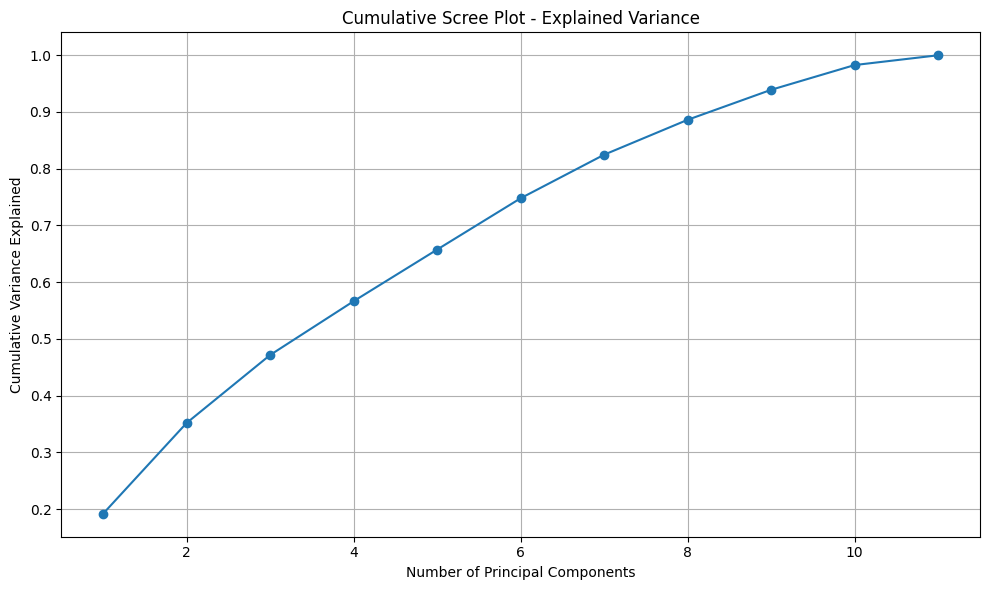

In [103]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), cumulative_variance, marker='o')
plt.title("Cumulative Scree Plot - Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that almost all features contribute to the variance and dropping a lot of them will affect model's performance badly

#### As Non-linear SVM takes a lot of time in training, we will try the following three approaches:
1) Training, evaluating model on a balanced subset of data
2) Using RBF kernel approximation and training a linear SVM

- Training, evaluating model on a small subset of data

In [16]:
model = SVC(kernel='rbf', probability=True, verbose= True, class_weight='balanced')

In [17]:
# Create a balanced sample from the dataset
class_0 = df[df['anomaly'] == 0]
class_1 = df[df['anomaly'] == 1]

# Sample equal number from each class (based on minority class size)
min_len = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(min_len, random_state=42),
    class_1.sample(min_len, random_state=42)
], ignore_index=True).sample(frac=1, random_state=42)  # Shuffle

print(df_balanced['anomaly'].value_counts())

anomaly
1    37296
0    37296
Name: count, dtype: int64


In [18]:
# Separate features and target
y = df_balanced['anomaly'].values
X = df_balanced.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df_balanced['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Val/Test split with stratification
X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.1, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

33566 33566
3730 3730
(67132, 29) (67132,)
(7460, 29) (7460,)


In [11]:
# Fit the model
model.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', probability=True, verbose=True)

In [19]:
def evaluate(model, show=False):
    # Evaluate on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]  

    # Set prediction to 0 where meter_reading is missing
    test_pred = np.where(meter_test == -1, 0, test_pred)

    # Metrics on test set
    test_acc = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_auprc = average_precision_score(y_test, test_pred_proba)
    
    if show:
        print("Linear SVM Test Set Metrics:")
        print(f"    Acc: {test_acc}")
        print(f"    F1: {test_f1}")
        print(f"    AUC: {test_auc}")
        print(f"    AUC-PR: {test_auprc}")
        print(f"    Precision: {test_precision}")
        print(f"    Recall: {test_recall}")

        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix on Test Set")
        plt.show()

        # Calculate zeroR baseline metrics
        zeroR = np.bincount(y_test).argmax()
        y_pred_zeroR = np.full_like(y_test, zeroR)
        zeroR_acc = accuracy_score(y_test, y_pred_zeroR)
        zeroR_f1 = f1_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_precision = precision_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_recall = recall_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_auc = roc_auc_score(y_test, y_pred_zeroR)
        zeroR_auprc = average_precision_score(y_test, y_pred_zeroR)

        print(f"ZeroR Baseline Metrics:")
        print(f"    Accuracy: {zeroR_acc}")
        print(f"    F1 Score: {zeroR_f1}")
        print(f"    Precision: {zeroR_precision}")
        print(f"    Recall: {zeroR_recall}")
        print(f"    AUC: {zeroR_auc}")
        print(f"    AUC-PR: {zeroR_auprc}")

Linear SVM Test Set Metrics:
    Acc: 0.8281501340482573
    F1: 0.8235617946600605
    AUC: 0.8956263611468492
    AUC-PR: 0.8980557669447744
    Precision: 0.8461538461538461
    Recall: 0.8021447721179624


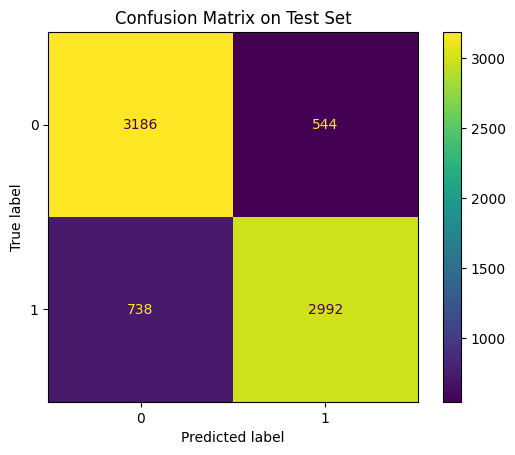

ZeroR Baseline Metrics:
    Accuracy: 0.5
    F1 Score: 0.0
    Precision: 0.0
    Recall: 0.0
    AUC: 0.5
    AUC-PR: 0.5


In [ ]:
evaluate(model, show=True)

We can see that Non-linear SVM gives better results than linear models like logistic regression if the dataset was balanced

In [105]:
# Train/Test split with stratification
X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, train_size=0.125, test_size=0.2 * 0.125, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

4662 200568
932 40115
(205230, 11) (205230,)
(41047, 11) (41047,)


In [ ]:
model = SVC(kernel='rbf', probability=True, verbose= True, class_weight='balanced')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
evaluate(model, show=True)
# Evaluate on train set
train_pred = model.predict(X_train)
train_pred_proba = model.predict_proba(X_train)[:, 1]  

# Metrics on train set
train_acc = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred, zero_division=0)
train_auc = roc_auc_score(y_train, train_pred_proba)
train_precision = precision_score(y_train, train_pred, zero_division=0)
train_recall = recall_score(y_train, train_pred, zero_division=0)
train_auprc = average_precision_score(y_train, train_pred_proba)

print(f" Acc: {train_acc:<10.2f} F1: {train_f1:<10.2f} AUC: {train_auc:<10.2f} Precision: {train_precision:<10.2f} Recall: {train_recall:<10.2f} AUPRC: {train_auprc:<10.2f}")

- Using RBF kernel approximation

In [71]:
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

In [72]:
# Train/Test split with stratification
X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.2, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

29837 1369758
7459 342440
(1399595, 29) (1399595,)
(349899, 29) (349899,)


In [73]:
rbf_feature = RBFSampler(gamma=0.5, n_components=400, random_state=42)
X_train_features = rbf_feature.fit_transform(X_train)
X_test_features = rbf_feature.transform(X_test)

In [33]:
print(X_train_features.shape)

(1399595, 400)


In [ ]:
def evaluate(model, show=False):
    
    train_pred = model.predict(X_train_features)
    train_pred_proba = model.decision_function(X_train_features)
    test_pred = model.predict(X_test_features)
    test_pred_proba = model.decision_function(X_test_features)

    # Set prediction to 0 where meter_reading is missing
    test_pred = np.where(meter_test == -1, 0, test_pred)

    # Metrics on train set
    train_acc = accuracy_score(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred, zero_division=0)
    train_auc = roc_auc_score(y_train, train_pred_proba)
    train_precision = precision_score(y_train, train_pred, zero_division=0)
    train_recall = recall_score(y_train, train_pred, zero_division=0)
    train_auprc = average_precision_score(y_train, train_pred_proba)

    # Metrics on test set
    test_acc = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_auprc = average_precision_score(y_test, test_pred_proba)
    
    if show:
        print("Linear SVM Test Set Metrics:")
        print(f"    Acc: {test_acc}")
        print(f"    F1: {test_f1}")
        print(f"    AUC: {test_auc}")
        print(f"    AUC-PR: {test_auprc}")
        print(f"    Precision: {test_precision}")
        print(f"    Recall: {test_recall}")

        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix on Test Set")
        plt.show()

        # Calculate zeroR baseline metrics
        zeroR = np.bincount(y_test).argmax()
        y_pred_zeroR = np.full_like(y_test, zeroR)
        zeroR_acc = accuracy_score(y_test, y_pred_zeroR)
        zeroR_f1 = f1_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_precision = precision_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_recall = recall_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_auc = roc_auc_score(y_test, y_pred_zeroR)
        zeroR_auprc = average_precision_score(y_test, y_pred_zeroR)

        print(f"ZeroR Baseline Metrics:")
        print(f"    Accuracy: {zeroR_acc}")
        print(f"    F1 Score: {zeroR_f1}")
        print(f"    Precision: {zeroR_precision}")
        print(f"    Recall: {zeroR_recall}")
        print(f"    AUC: {zeroR_auc}")
        print(f"    AUC-PR: {zeroR_auprc}")
    return {
        'Test' : {
            "Accuracy" : test_acc, 
            "F1" : test_f1, 
            "AUC" : test_auc, 
            "Precision" : test_precision, 
            "Recall" : test_recall, 
            "AUPRC" : test_auprc
        },
        'Train' : {
            "Accuracy" : train_acc, 
            "F1" : train_f1, 
            "AUC" : train_auc, 
            "Precision" : train_precision, 
            "Recall" : train_recall, 
            "AUPRC" : train_auprc
        }
    }

In [ ]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
alphas = [1 / (X_train_features.shape[0] * C) for C in C_values]
scores = []
best_model = None
best_score = 0
for i, alpha in enumerate(alphas):
    model = SGDClassifier(loss="hinge", alpha=alpha, max_iter=1000, random_state=42, class_weight='balanced')
    model.fit(X_train_features, y_train)
    score = evaluate(model, show=False)
    print(f"For C = {C_values[i]}, Test F1 Score = {score['Test']['F1']}")
    if score['Test']['F1'] > best_score:
        best_score = score['Test']['F1']
        best_model = model
    scores.append(score)

For C = 0.0001, Test F1 Score = 0.044459792204672395
For C = 0.001, Test F1 Score = 0.043736711936477636
For C = 0.01, Test F1 Score = 0.04440375371938659
For C = 0.1, Test F1 Score = 0.04390082256366374
For C = 1, Test F1 Score = 0.04394369108916008
For C = 10, Test F1 Score = 0.042576928200346344
For C = 100, Test F1 Score = 0.039659959551640214
For C = 1000, Test F1 Score = 0.04335275193461438
For C = 10000, Test F1 Score = 0.041643822264458986


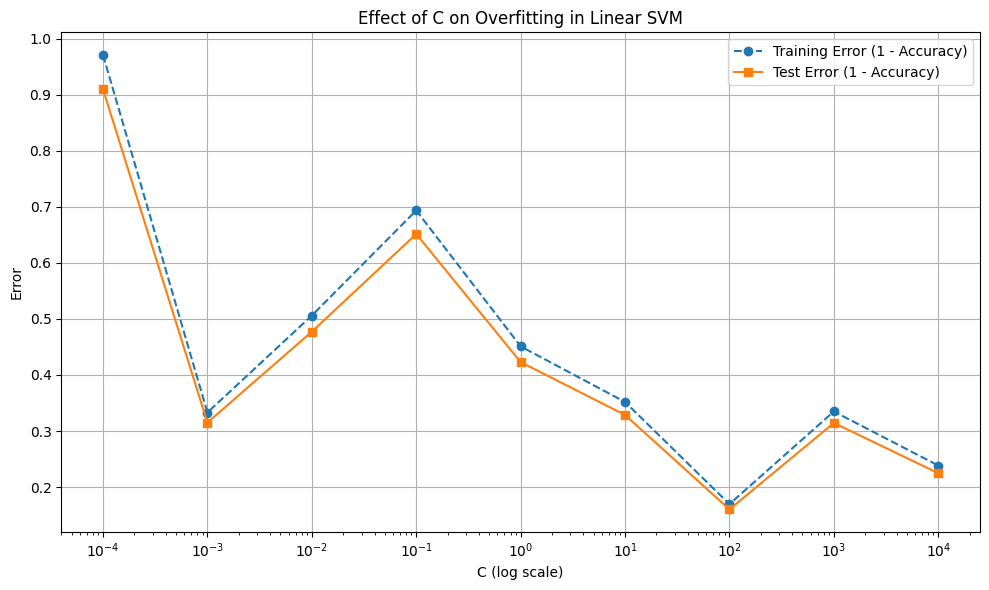

In [104]:
# Convert metric lists to numpy arrays for scaling
test_f1_scores = np.array([s['Test']['F1'] for s in scores])
test_accuracies = np.array([s['Test']['Accuracy'] for s in scores])

Eout_accuracy = 1 - test_accuracies
Eout_f1 = 1 - test_f1_scores

train_f1_scores = np.array([s['Train']['F1'] for s in scores])
train_accuracies = np.array([s['Train']['Accuracy'] for s in scores])

Ein_accuracy = 1 - train_accuracies
Ein_f1 = 1 - train_f1_scores

plt.figure(figsize=(10, 6))

# Plot Accuracy errors
plt.plot(C_values, Ein_accuracy, marker='o', label='Training Error (1 - Accuracy)', linestyle='--')
plt.plot(C_values, Eout_accuracy, marker='s', label='Test Error (1 - Accuracy)', linestyle='-')

# Plot F1 errors
# plt.plot(C_values, Ein_f1, marker='^', label='Training Error (1 - F1)', linestyle='--')
# plt.plot(C_values, Eout_f1, marker='d', label='Test Error (1 - F1)', linestyle='-')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Error')
plt.title('Effect of C on Overfitting in Linear SVM')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Linear SVM Test Set Metrics:
    Acc: 0.09055470292855938
    F1: 0.044459792204672395
    AUC: 0.5061050336473975
    AUC-PR: 0.021851670962697207
    Precision: 0.02273921016337952
    Recall: 0.9924922911918488


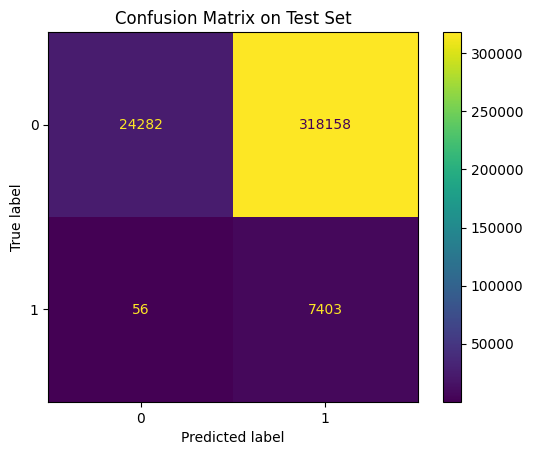

ZeroR Baseline Metrics:
    Accuracy: 0.9786824197839948
    F1 Score: 0.0
    Precision: 0.0
    Recall: 0.0
    AUC: 0.5
    AUC-PR: 0.02131758021600519


In [89]:
_ = evaluate(best_model, show=True)